# Import Library

In [1]:
# Import library
import joblib
import pandas as pd
import numpy as np
from collections import Counter

# Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler

# Model & Evaluation Metrics
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt


# Load File

In [ ]:
# Load File -----------------------------------------------------------------------------------------------------------------------------------
file_path = r"..\Pre_Emotion_Dataset\8_Lemmatization_new.csv"
df = pd.read_csv(file_path)

# TF-IDF Vectorization （Feature Engineering）---------------------------------------------------------------------------------------------------
tfidf = TfidfVectorizer(max_features=10000)
textData = tfidf.fit_transform(df['text'])

x = textData
y = df['label']
label_encoder = LabelEncoder() # Encode target labels into numeric values
y = label_encoder.fit_transform(y)

# Train Test Split -------------------------------------------------------------------------------------------------------------------------------
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y,random_state=42)
print("Train distribution:", Counter(y_train))
print("Test distribution:", Counter(y_test))

# Resampling --------------------------------------------------------------------------------------------------------------------------------------
print("Class distribution before resampling (70% Train Set):", Counter(y_train))
undersampler = RandomUnderSampler(random_state=42)

x_train_resampled, y_train_resampled = undersampler.fit_resample(x_train, y_train)
print("Class distribution after resampling (70% Train Set):", Counter(y_train_resampled))
print("Class distribution (30% test set):", Counter(y_test))

Train distribution: Counter({0: 94944, 1: 38286, 2: 31950})
Test distribution: Counter({0: 40691, 1: 16408, 2: 13693})
Class distribution before resampling (70% Train Set): Counter({0: 94944, 1: 38286, 2: 31950})
Class distribution after resampling (70% Train Set): Counter({0: 31950, 1: 31950, 2: 31950})
Class distribution (30% test set): Counter({0: 40691, 1: 16408, 2: 13693})


# Model

In [ ]:
best_params = {
    'reg_lambda': 10,
    'reg_alpha': 1,
}

xgb_fine = XGBClassifier(
    objective='multi:softmax',  
    num_class=3, 
    eval_metric='mlogloss', 
    random_state=42,
    # **best_params
)

eval_set = [(x_train_resampled, y_train_resampled), (x_test, y_test)]  
xgb_fine.fit(x_train_resampled, y_train_resampled, 
        eval_set=eval_set, 
        verbose=True, )

# Save Model
joblib.dump(xgb_fine, "XGB_Emotion_Fine_Model.pkl")
print("Training completed and model saved.")


[0]	validation_0-mlogloss:1.05981	validation_1-mlogloss:1.07831
[1]	validation_0-mlogloss:1.02418	validation_1-mlogloss:1.06148
[2]	validation_0-mlogloss:0.99030	validation_1-mlogloss:1.04329
[3]	validation_0-mlogloss:0.95741	validation_1-mlogloss:1.02750
[4]	validation_0-mlogloss:0.92829	validation_1-mlogloss:1.01386
[5]	validation_0-mlogloss:0.90254	validation_1-mlogloss:1.00058
[6]	validation_0-mlogloss:0.87824	validation_1-mlogloss:0.98612
[7]	validation_0-mlogloss:0.85508	validation_1-mlogloss:0.97444
[8]	validation_0-mlogloss:0.83255	validation_1-mlogloss:0.96266
[9]	validation_0-mlogloss:0.81140	validation_1-mlogloss:0.95176
[10]	validation_0-mlogloss:0.79146	validation_1-mlogloss:0.93991
[11]	validation_0-mlogloss:0.77294	validation_1-mlogloss:0.93013
[12]	validation_0-mlogloss:0.75523	validation_1-mlogloss:0.92077
[13]	validation_0-mlogloss:0.73810	validation_1-mlogloss:0.91267
[14]	validation_0-mlogloss:0.72145	validation_1-mlogloss:0.90119
[15]	validation_0-mlogloss:0.70596	

## Evaluate Model

In [ ]:
# Evaluate Model ---------------------------------------------------------------------------------------------------------------------
y_train_pred = xgb_fine.predict(x_train_resampled)
y_test_pred = xgb_fine.predict(x_test)

y_train_pred_prob = xgb_fine.predict_proba(x_train_resampled)  
y_test_pred_prob = xgb_fine.predict_proba(x_test)

train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(y_test, y_test_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(y_test, y_test_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(y_test, y_test_pred, average='weighted') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(y_test, y_test_pred, average='weighted')
print(f"📌 Recall: {recall:.4f}")

roc_auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')
print(f"\n📌 Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(y_test, y_test_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))  



📌 Train Accuracy: 0.9614
📌 Test Accuracy: 0.9567

📌 Weighted F1 Score: 0.9571
📌 Micro F1 Score: 0.9567
📌 Macro F1 Score: 0.9460

📌 Precision: 0.9588
📌 Recall: 0.9567

📌 Test ROC AUC: 0.9934

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     40691
           1       0.89      0.97      0.93     16408
           2       0.93      0.93      0.93     13693

    accuracy                           0.96     70792
   macro avg       0.94      0.95      0.95     70792
weighted avg       0.96      0.96      0.96     70792


📌 Confusion Matrix:
[[39041   970   680]
 [  173 15964   271]
 [   40   932 12721]]


## Loss Curve

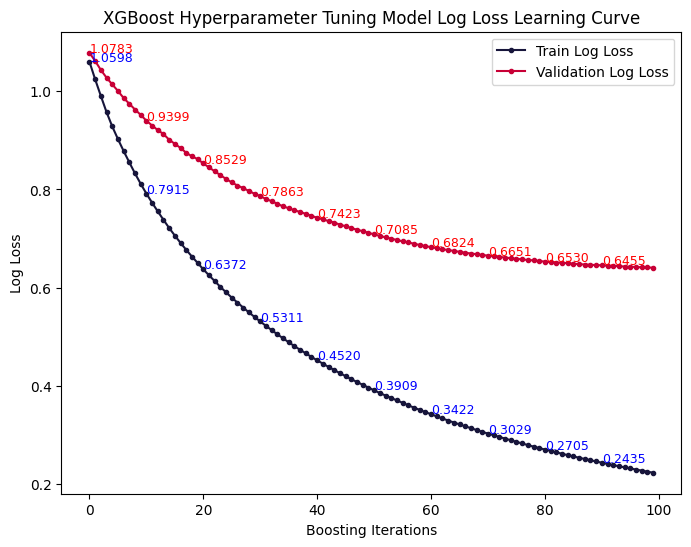

In [10]:
results = xgb_fine.evals_result()

epochs = len(results['validation_0']['mlogloss'])  
x_axis = range(epochs)

plt.figure(figsize=(8, 6))
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train Log Loss', marker='.',color='#17153B')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Validation Log Loss', marker='.',color='#C80036')

for i in range(0, epochs, max(1, epochs // 10)):
    plt.text(x_axis[i], results['validation_0']['mlogloss'][i] + 0.001, 
             f"{results['validation_0']['mlogloss'][i]:.4f}", 
             fontsize=9, ha='left', color='blue')
    
    plt.text(x_axis[i], results['validation_1']['mlogloss'][i] + 0.001, 
             f"{results['validation_1']['mlogloss'][i]:.4f}", 
             fontsize=9, ha='left', color='red')


plt.xlabel("Boosting Iterations")
plt.ylabel("Log Loss")
plt.title("XGBoost Hyperparameter Tuning Model Log Loss Learning Curve")
plt.legend()
plt.show()

## Learning Curve

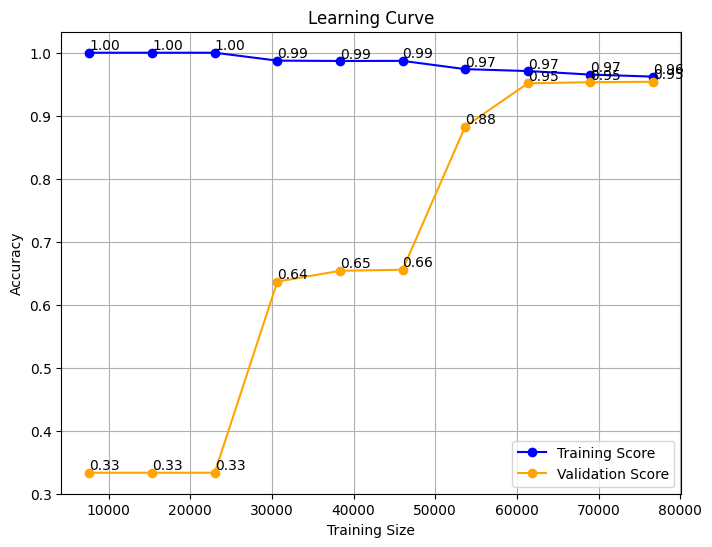

In [11]:
train_sizes, train_scores, test_scores = learning_curve(
    xgb_fine, x_train_resampled, y_train_resampled,  scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 6))

plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue', marker='o')

for i, txt in enumerate(train_scores_mean):
    plt.text(train_sizes[i], train_scores_mean[i], f"{txt:.2f}", fontsize=10, verticalalignment='bottom')

plt.plot(train_sizes, test_scores_mean, label='Validation Score', color='orange', marker='o')

for i, txt in enumerate(test_scores_mean):
    plt.text(train_sizes[i], test_scores_mean[i], f"{txt:.2f}", fontsize=10, verticalalignment='bottom')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True) 
plt.show()


## precision_recall_curve

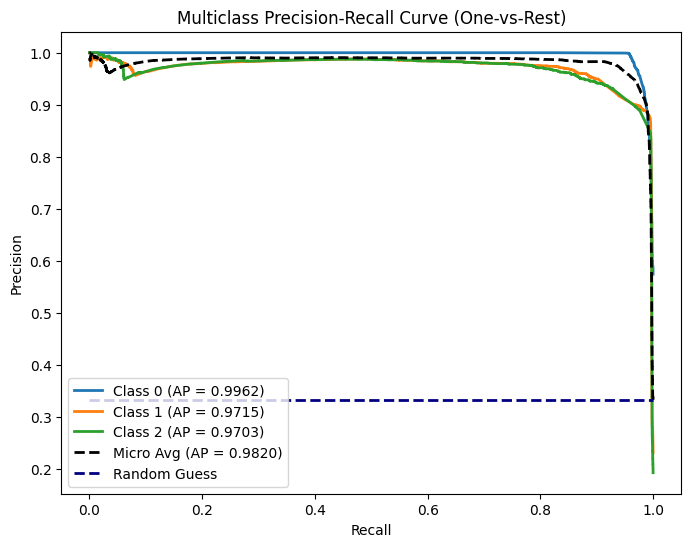

In [28]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

y_test_probs = xgb_fine.predict_proba(x_test) 

num_classes = y_test_probs.shape[1]
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

precision = dict()
recall = dict()
pr_auc = dict()

plt.figure(figsize=(8, 6))

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_test_probs[:, i])
    pr_auc[i] = average_precision_score(y_test_bin[:, i], y_test_probs[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {pr_auc[i]:.4f})')

precision_micro, recall_micro, _ = precision_recall_curve(y_test_bin.ravel(), y_test_probs.ravel())
pr_auc_micro = average_precision_score(y_test_bin, y_test_probs, average="micro")
plt.plot(recall_micro, precision_micro, color='black', linestyle='--', lw=2, label=f'Micro Avg (AP = {pr_auc_micro:.4f})')

plt.plot([0, 1], [np.mean(y_test_bin)] * 2, color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve (One-vs-Rest)')
plt.legend(loc="lower left")
plt.show()


## ROC-AUC Curve

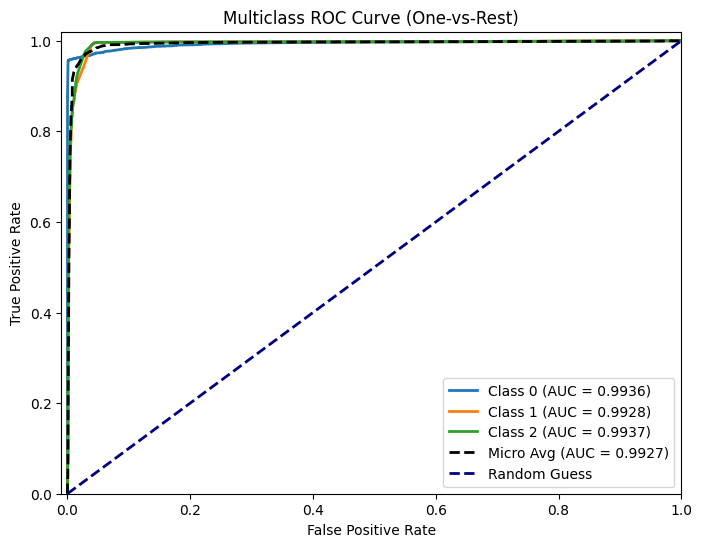

In [23]:
y_pred_prob = xgb_fine.predict_proba(x_test) 
num_classes = 3

y_test_bin = label_binarize(y_test, classes=[0, 1, 2]) 
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(8, 6))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='black', linestyle='--', lw=2, label=f'Micro Avg (AUC = {roc_auc_micro:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()


## Confusion Matrix

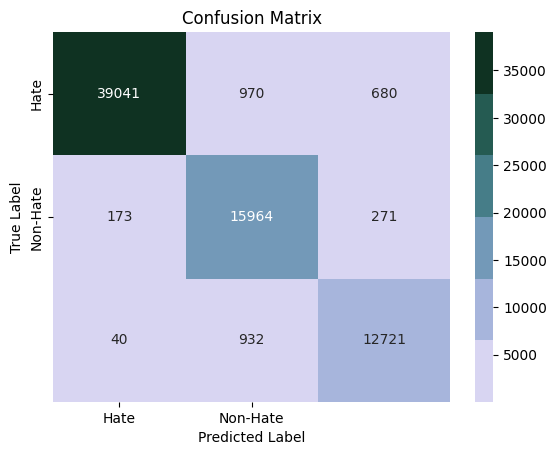

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap = sns.cubehelix_palette(start=2),
            xticklabels=['Hate', 'Non-Hate'], 
            yticklabels=['Hate', 'Non-Hate'])

plt.xlabel("Predicted Label") 
plt.ylabel("True Label")  
plt.title("Confusion Matrix") 
plt.show()

